In [1]:
import os
import sys
import pandas as pd
import yaml
import matplotlib.pyplot as plt

parameters = {}
with open("../parameters.yml", 'r') as stream:
    try:
        parameters = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

csvFile = '../src/data/processed/' + parameters['parsed_file']
tweets = pd.read_csv(csvFile, sep=',')


repliesCsvFile = '../src/data/processed/' + parameters['reply_file']
replies = pd.read_csv(repliesCsvFile, sep=',')

dataCsvFile = '../src/data/classes/' + parameters['class_name'] + '/' + 'index.csv'
data = pd.read_csv(dataCsvFile, sep='\t')
data = data.append({'name': 'other', 'token': 'other', 'tags': ''}, ignore_index=True)


### - Topic based approach

In [12]:
processed = {
    't_hate': 0, 't_all': 0,  # trump's hate
    'h_hate': 0, 'h_all': 0, # hurricane hate
    'g_hate': 0, 'g_all': 0 # general hate
}

hurricaneTags = ['Dorian', 'Bhamas', 'Hurricane', 'Carolina', 'Alabama']

for index, element in tweets.iterrows():
    vote = str(element['vote'])
    found = []
    if 'nan' == vote:
        continue
    if '0.0' != vote: 
        # detected politicians:
        politicians = element['matches'].split("####")
        for politician in politicians:
            for position, datum in data.iterrows():
                if politician.startswith(datum['token']):
                    if politician in found:
                        continue
                    found.append(politician)
                    # check replies
                    tempest_replies = replies.loc[replies['tweet_id'] == element['tweet_id']]
                    # check hates
                    tempest_hate = tempest_replies.loc[tempest_replies['automatic'] == 1]
                    if 'Donald_Trump' == datum['token']:
                        processed['t_hate'] = processed['t_hate'] + len(tempest_hate)
                        processed['t_all'] = processed['t_all'] + len(tempest_hate)

                        
for index, element in replies.iterrows():
    is_general = True 
    if 'Trump' in element['text']:
        is_general = False
        processed['t_all'] = processed['t_all'] + 1
        if element['automatic'] == 1:
            processed['t_hate'] = processed['t_hate'] + 1     
    for hurricaneTag in hurricaneTags:
        if 'Hurricane' in element['text']:
            is_general = False
            processed['h_all'] = processed['h_all'] + 1
            if element['automatic'] == 1:
                processed['h_hate'] = processed['h_hate'] + 1     
    if not is_general:
        processed['g_all'] = processed['g_all'] + 1
        if element['automatic'] == 1:
            processed['g_hate'] = processed['g_hate'] + 1     
    
print(processed)                    

{'t_hate': 3, 't_all': 14, 'h_hate': 0, 'h_all': 5, 'g_hate': 2, 'g_all': 14}


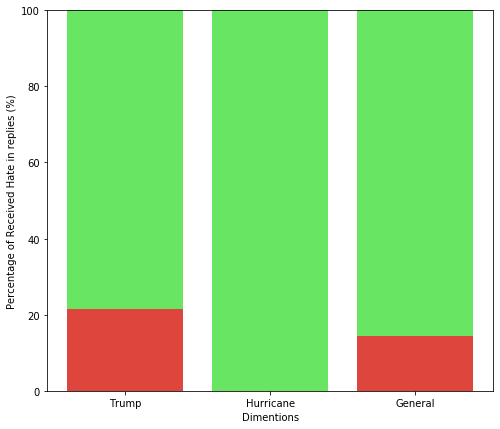

In [16]:
percentages = [0, 0 , 0];
negativePercentages = [100, 100 , 100];
titles = ['Trump', 'Hurricane', 'General']
percentages[0] = processed['t_hate'] * 100 / processed['t_all']
negativePercentages[0] = negativePercentages[0] - percentages[0]
percentages[1] = processed['h_hate'] * 100 / processed['h_all']
negativePercentages[1] = negativePercentages[1] - percentages[1]
percentages[2] = processed['g_hate'] * 100 / processed['g_all']
negativePercentages[2] = negativePercentages[2] - percentages[2]

# Hate distribtion:
plt.figure(figsize=(8,7))
plt.bar(titles, percentages, color='#de453d')
plt.bar(titles, negativePercentages, bottom=percentages, color='#68e563')
plt.xlabel('Dimentions')
plt.ylabel('Percentage of Received Hate in replies (%)')
plt.ylim(0, 100)
plt.show()
